In [ ]:
!pip install kaggle

In [1]:
import os
import glob
import zipfile

import functools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

tf.enable_eager_execution()

# Get all the files

In [ ]:
import os

def get_kaggle_credentials():
    token_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
    token_file = os.path.join(token_dir, "kaggle.json")
    if not os.path.isdir(token_dir):
        os.mkdir(token_dir)
    try:
        with open(token_file,'r') as f:
            pass
    except IOError as no_file:
        try:
            from google.colab import files
        except ImportError:
            raise no_file

        uploaded = files.upload()

        if "kaggle.json" not in uploaded:
            raise ValueError("You need an API key! see:"
                             "https://github.com/Kaggle/kaggle-api#api-credentials")
        with open(token_file, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(token_file, 600)

get_kaggle_credentials()                

In [ ]:
import kaggle

# Download data from Kaggle

In [3]:
competition_name = 'carvana-image-masking-challenge'

In [ ]:
def load_data_from_zip(competition, file):
    with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
        unzipped_file = zip_ref.namelist()[0]
        zip_ref.extractall(competition)
        
def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')

get_data(competition_name)

In [4]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [5]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [6]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [7]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(
    x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [8]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


In [ ]:
x_train_filenames[:10]

In [ ]:
y_train_filenames[:10]

# Visualize

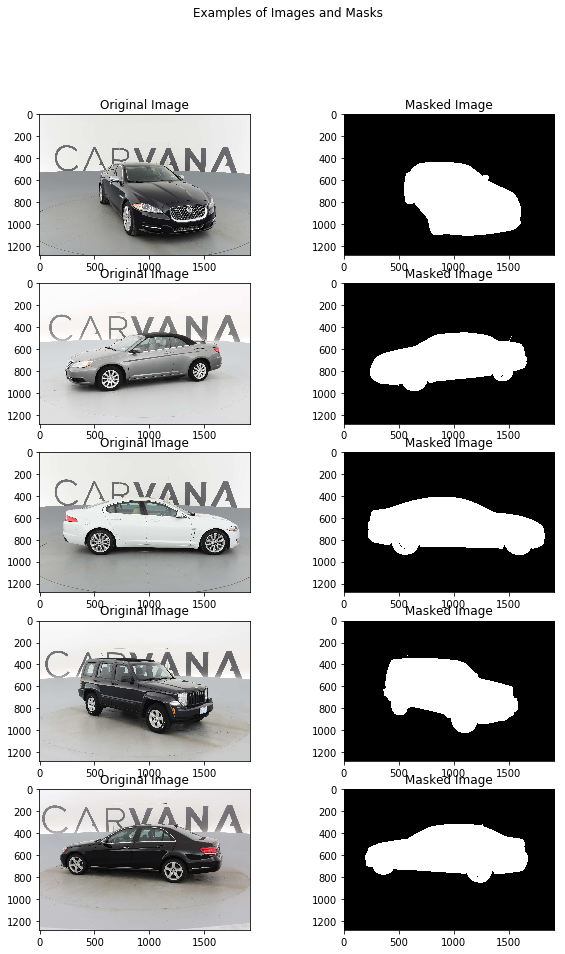

In [9]:
display_num = 5

r_choice = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num*2, 2):
    idx = i // 2
    x_path = x_train_filenames[idx]
    y_path = y_train_filenames[idx]
    
    plt.subplot(display_num, 2, i+1)
    plt.imshow(plt.imread(x_path))
    plt.title("Original Image")
    
    plt.subplot(display_num, 2, i+2)
    plt.imshow(plt.imread(y_path))
    plt.title("Masked Image")
    
#     example_labels = Image.open(y_path)
#     label_vals = np.unique(example_labels)  
#     plt.subplot(display_num, 2, i + 2)
#     plt.imshow(example_labels)
#     plt.title("Masked Image") 

plt.suptitle("Examples of Images and Masks")
plt.show()


# Set up

In [10]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 5

# Build the input pipeline

## Convert each file name to image

In [31]:
def _process_pathnames(fname, label_path):
    """Convet input file name amd label path into image and mask."""
    img = tf.image.decode_jpeg(tf.read_file(fname), channels=3)
    label_img = tf.image.decode_gif(tf.read_file(label_path))[0]
    label_img = tf.expand_dims(label_img[:,:,0], axis=-1)
    return img, label_img

(1280, 1918, 3) (1280, 1918, 1)


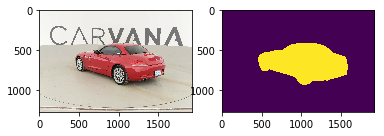

In [34]:
img, mask = _process_pathnames(x_train_filenames[5], y_train_filenames[5])

print(img.shape, mask.shape)

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])


## Shifting the image

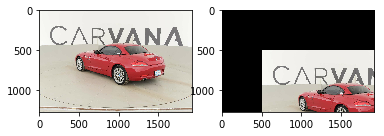

In [35]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(tfcontrib.image.translate(img, [500, 500]))

In [61]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        # randomly select a number from [-shift, shift]
        if width_shift_range:
            width_shift_range = tf.random_uniform([], minval=-img_shape[1]*width_shift_range,
                                                 maxval=img_shape[1]*width_shift_range)
            
        if height_shift_range:
            height_shift_range = tf.random_uniform([], minval=-img_shape[0]*height_shift_range,
                                                 maxval=img_shape[0]*height_shift_range)
            
        output_img = tfcontrib.image.translate(output_img, [width_shift_range, height_shift_range])
        label_img = tfcontrib.image.translate(label_img, [width_shift_range, height_shift_range])
        
    return output_img, label_img
    

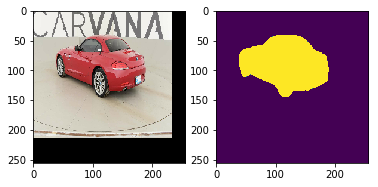

In [82]:
img2, mask2 = shift_img(tf.image.resize(img, img_shape[:-1]), tf.image.resize(mask, img_shape[:-1]), 0.5, 0.5)

plt.subplot(1,2,1)
plt.imshow(img2/255)
plt.subplot(1,2,2)
plt.imshow(mask2[:,:,0])

## Flipping the image randomly

In [135]:
def flip_img(horizontal_flip, tr_img, label_img):
    """Flip the image and mask at the probability of 0.5"""    
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                    lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                    lambda: (tr_img, label_img))
        
#         to_flip = tf.random_uniform([], 0.0, 1.0).numpy() > 0.5

#         if to_flip:
#             tr_img = tf.image.flip_left_right(tr_img)
#             label_img = tf.image.flip_left_right(label_img)
        
    return tr_img, label_img
    
    

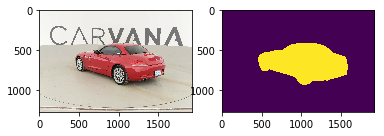

In [137]:
img2, mask2 = flip_img(True, img, mask)

plt.subplot(1,2,1)
plt.imshow(img2)
plt.subplot(1,2,2)
plt.imshow(mask2[:,:,0])

## Assemble into the augment function

In [111]:
def _augment(img, label_img,
             resize=None,
             scale=1,
             hue_delta=0,
             horizontal_flip=False,
             width_shift_range=0,
             height_shift_range=0):
    if resize is not None:
        # resize both image and mask
        img = tf.image.resize(img, resize)
        label_img = tf.image.resize(label_img, resize)
        
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
        
        
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    
    img = tf.to_float(img) * scale
    label_img = tf.to_float(label_img) * scale
    
    return img, label_img

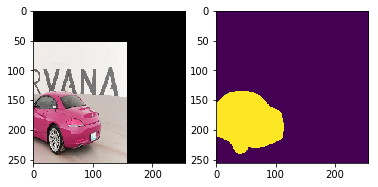

In [124]:
img2, mask2 = _augment(img, mask, resize=img_shape[:-1], scale=1/255.0, hue_delta=0.2, horizontal_flip=True,
                      width_shift_range=0.5, height_shift_range=0.3)

plt.subplot(1,2,1)
plt.imshow(img2)
plt.subplot(1,2,2)
plt.imshow(mask2[:,:,0])

In [125]:
def get_baseline_dataset(filenames, labels, preproc_fn=functools.partial(_augment),
                         threads=5, batch_size=batch_size, shuffle=True):
    """Create a TF Dataset from filenames"""
    num_x = len(filenames)
    
    # 1. Create a dataset of filenames
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    # 2. Convert filenames into images
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    
    # 3. Augment data
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, """Batching images must be of the same size"""
        
    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
    
    if shuffle:
        dataset.shuffle(num_x)
        
    return dataset.repeat().batch(batch_size)
    

## Set up training and validation datasets

In [131]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1/255.0,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1    
}

tr_preproc_fn = functools.partial(_augment, **tr_cfg)


In [130]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1/255.0,
}
val_preproc_fn = functools.partial(_augment, **val_cfg)

In [138]:
train_ds = get_baseline_dataset(x_train_filenames, y_train_filenames, preproc_fn=tr_preproc_fn, batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames, y_val_filenames, preproc_fn=val_preproc_fn, batch_size=batch_size)

Instructions for updating:
Colocations handled automatically by placer.


## Check the input pipeline

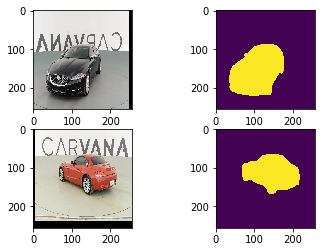

In [164]:
temp_ds = get_baseline_dataset(x_train_filenames, y_train_filenames, preproc_fn=tr_preproc_fn,
                              batch_size=1, shuffle=False)
n_x = len(x_train_filenames)
for i, x in enumerate(temp_ds):
    if i is 0:        
        plt.subplot(2,2,1)
        plt.imshow(x[0][0,:,:,:])
        plt.subplot(2,2,2)
        plt.imshow(x[1][0,:,:,0])
        
    if i is 5:
        plt.subplot(2,2,3)
        plt.imshow(x[0][0,:,:,:]).
        plt.subplot(2,2,4)
        plt.imshow(x[1][0,:,:,0])
        
    if i > 5:
        break